# 01 - Modelo emparejamiento clip con audio.
*Monserrat Montero T.*

## Parte 1: Exploración y extracción de features para un solo wav

In [4]:
from pathlib import Path
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os

# Configuración general
sr_target = 48000
n_mfcc = 20
hop_length = 512 
# Rutas de ejemplo
base_path = Path("clips_syntrack/bzrp_session_milo_j_bizarrap")
song_path = base_path / "cancion_estudio/bzrp_session_milo_j_bizarrap.wav"
clip_path = base_path / "clips_youtube/wavs/clip04.wav"

In [39]:
song, sr_song = librosa.load(song_path, sr=sr_target)
clip, sr_clip = librosa.load(clip_path, sr=sr_target)

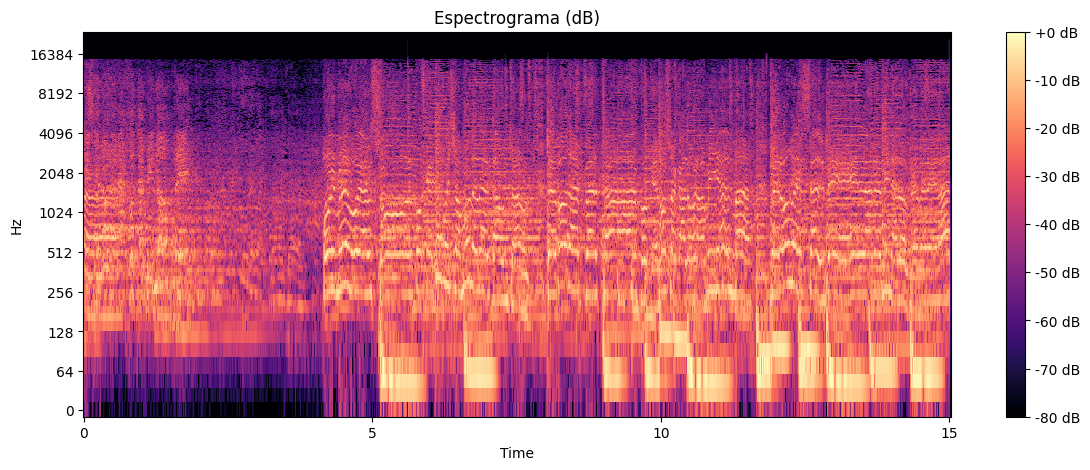

In [40]:
spec = librosa.amplitude_to_db(np.abs(librosa.stft(clip)), ref=np.max)
plt.figure(figsize=(14, 5))
librosa.display.specshow(spec, sr=sr_clip, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Espectrograma (dB)")
plt.show()

Shape MFCC: (20, 1410)


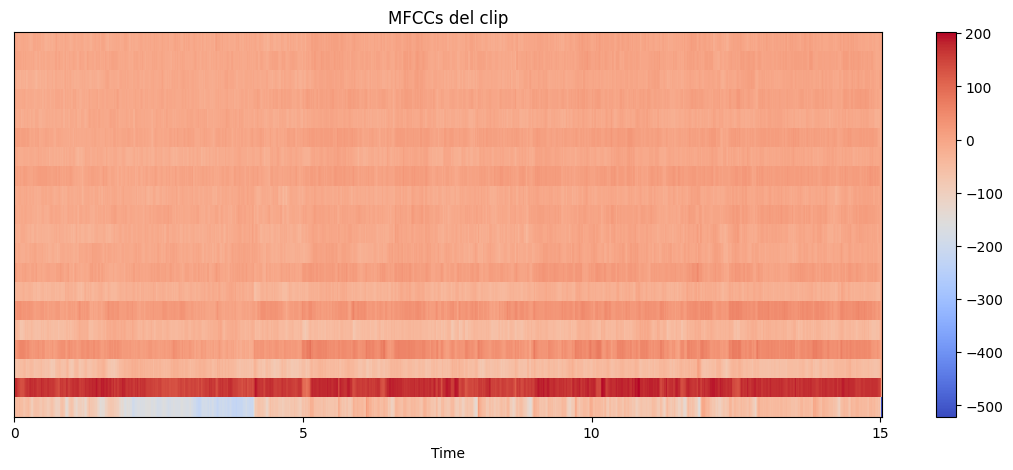

In [41]:
mfcc = librosa.feature.mfcc(y=clip, sr=sr_clip, n_mfcc=n_mfcc, hop_length=hop_length)
print("Shape MFCC:", mfcc.shape)

plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc, sr=sr_clip, hop_length=hop_length, x_axis='time')
plt.colorbar()
plt.title("MFCCs del clip")
plt.show()

In [42]:
clip_vector = mfcc.mean(axis=1)
print("Vector MFCC resumen (shape):", clip_vector.shape)

Vector MFCC resumen (shape): (20,)


## Parte 2: Clasificador simple

In [5]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [6]:
# Ruta al archivo Excel
ruta_excel = Path("etiquetado.xlsx")  # cámbiala si está en otro lado

# Leer
df = pd.read_excel(ruta_excel)
# Eliminar columnas completamente vacías
df = df.dropna(axis=1, how='all')

# Convertir la columna de segundos a segundos reales
def convertir_a_segundos(valor):
    if isinstance(valor, str):
        if ":" in valor:
            minutos, segundos = map(int, valor.split(":"))
            return minutos * 60 + segundos
    if isinstance(valor, (int, float)) and valor >= 0:
        return int(valor)
    return -1  # inválido

df["segundo_label"] = df["segundo_inicio"].apply(convertir_a_segundos)

# Eliminar columnas específicas que no usaremos para entrenamiento
df = df.drop(columns=["Unnamed: 7", "Unnamed: 8"], errors="ignore")


# Filtrar clips válidos (con etiqueta conocida)
df_validos = df[df["segundo_label"] >= 0].reset_index(drop=True)
print(f"✅ Clips válidos para entrenamiento: {len(df_validos)}")

df_validos 

✅ Clips válidos para entrenamiento: 196


,audio_base,carpeta,archivo_clip,segundo_inicio,duracion_clip,segundo_label
0,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip01.mp4,00:00,15,0
1,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip02.mp4,00:15,15,15
2,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip03.mp4,00:30,15,30
3,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip04.mp4,00:45,15,45
4,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip05.mp4,01:00,15,60
...,...,...,...,...,...,...
191,tu_me_dejaste_de_querer_c_tangana.mp3,clips_youtube,clip07.mp4,01:47,15,107
192,tu_me_dejaste_de_querer_c_tangana.mp3,clips_youtube,clip08.mp4,02:03,15,123
193,tu_me_dejaste_de_querer_c_tangana.mp3,clips_youtube,clip09.mp4,02:18,15,138
194,tu_me_dejaste_de_querer_c_tangana.mp3,clips_youtube,clip10.mp4,02:33,15,153


In [7]:
sr_target = 48000
n_mfcc = 20
hop_length = 512

X = []
y = []

# Tamaño de la ventana en frames (~1 segundo aprox. = 93 frames si hop=512)
ventana = 93
salto = 46  # 50% de superposición

for _, fila in df_validos.iterrows():
    # Sacar nombre base sin extensión
    base_audio = Path(fila["audio_base"]).stem  # 'bzrp_session_milo_j_bizarrap'
    
    # Construir ruta al wav
    nombre_wav = fila["archivo_clip"].replace(".mp4", ".wav")
    ruta_wav = Path("clips_syntrack") / base_audio / fila["carpeta"] / "wavs" / nombre_wav

    if not ruta_wav.exists():
        print(f"⚠️ No se encontró: {ruta_wav}")
        continue

    # Cargar y procesar audio
    audio, _ = librosa.load(ruta_wav, sr=sr_target)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr_target, n_mfcc=n_mfcc, hop_length=hop_length)
    mfcc = librosa.util.normalize(mfcc)

    # Extraer ventanas
    for i in range(0, mfcc.shape[1] - ventana + 1, salto):
        segmento = mfcc[:, i:i+ventana]
        vector = segmento.mean(axis=1)
        X.append(vector)
        y.append(fila["segundo_label"])  # misma etiqueta para cada segmento

X = np.array(X)
y = np.array(y)

print("✅ Dataset construido con múltiples ventanas:")
print("  X.shape:", X.shape)
print("  y.shape:", y.shape)

✅ Dataset construido con múltiples ventanas:
  X.shape: (6006, 20)
  y.shape: (6006,)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers

# Codificar etiquetas (los segundos de inicio) como índices enteros
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir datos
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Crear el modelo
model = models.Sequential([
    layers.Input(shape=(n_mfcc,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),  # regularización
    layers.Dense(32, activation='relu'),
    layers.Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento
history = model.fit(
    X_train, y_train_enc,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test_enc)
)

Epoch 1/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0280 - loss: 4.6178 - val_accuracy: 0.1007 - val_loss: 3.7129
Epoch 2/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1301 - loss: 3.5038 - val_accuracy: 0.2047 - val_loss: 2.9108
Epoch 3/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1988 - loss: 2.8590 - val_accuracy: 0.2920 - val_loss: 2.5215
Epoch 4/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2576 - loss: 2.5555 - val_accuracy: 0.3236 - val_loss: 2.3019
Epoch 5/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3086 - loss: 2.3229 - val_accuracy: 0.3411 - val_loss: 2.1622
Epoch 6/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3255 - loss: 2.1976 - val_accuracy: 0.3752 - val_loss: 2.0595
Epoch 7/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3449 - loss: 2.1033 - val_accuracy: 0.3943 - val_loss: 1.9705
Epoch 8/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3543 - loss: 2.0247 - val_accuracy: 0.

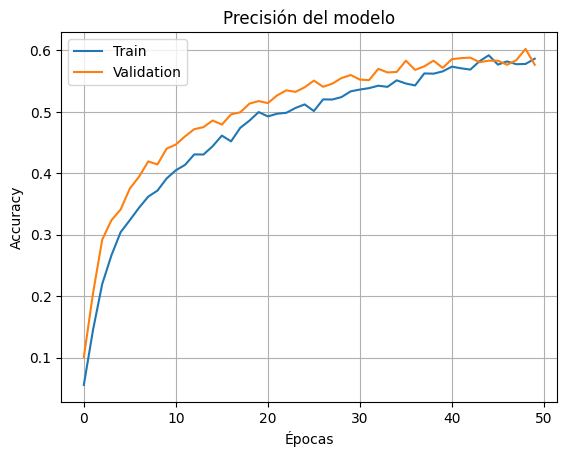

In [12]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Precisión del modelo")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
from collections import Counter

# ✏️ Selección del clip a probar
audio_base_prueba = "bzrp_session_milo_j_bizarrap.mp3"
archivo_clip_mp4 = "clip11.mp4"

# ➕ Construir ruta general
base_audio = Path(audio_base_prueba).stem
nombre_wav = archivo_clip_mp4.replace(".mp4", ".wav")
ruta_clip_prueba = Path("clips_syntrack") / base_audio / "clips_youtube" / "wavs" / nombre_wav

if not ruta_clip_prueba.exists():
    print(f"❌ El archivo no existe: {ruta_clip_prueba}")
else:
    # 🧠 Extraer MFCC
    audio_test, _ = librosa.load(ruta_clip_prueba, sr=sr_target)
    mfcc_test = librosa.feature.mfcc(y=audio_test, sr=sr_target, n_mfcc=n_mfcc, hop_length=hop_length)
    mfcc_test = librosa.util.normalize(mfcc_test)

    # 🪟 Cortar en ventanas y vectorizar
    X_test_clip = []
    for i in range(0, mfcc_test.shape[1] - ventana + 1, salto):
        segmento = mfcc_test[:, i:i+ventana]
        vector = segmento.mean(axis=1)
        X_test_clip.append(vector)

    # Normalizar con el scaler entrenado
    X_test_clip = scaler.transform(np.array(X_test_clip))

    # 🔮 Predecir
    preds = model.predict(X_test_clip)
    preds_segundos_idx = np.argmax(preds, axis=1)

    # Obtener la clase predicha más frecuente
    pred_mas_frecuente_idx = Counter(preds_segundos_idx).most_common(1)[0][0]
    pred_mas_frecuente_segundo = le.inverse_transform([pred_mas_frecuente_idx])[0]

    print(f"🎯 El modelo predice que el clip corresponde al segundo ~{pred_mas_frecuente_segundo}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
🎯 El modelo predice que el clip corresponde al segundo ~147
